In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


In [69]:

dataset_path = "/kaggle/input/rock-data/scidb_data"


batch_size = 32
img_size = (150, 150)
seed = 46

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=1, 
    seed=seed,
    shuffle=True
)

# manually split
full_ds_list = list(full_ds)  
num_samples = len(full_ds_list) 

# Calculate split sizes
train_size = int(0.8 * num_samples)  # 80% Train
val_size = int(0.15 * num_samples)  # 15% Validation
test_size = num_samples - train_size - val_size  # 5% Test

# Split dataset
train_ds_list = full_ds_list[:train_size]
val_ds_list = full_ds_list[train_size:train_size + val_size]
test_ds_list = full_ds_list[train_size + val_size:]

# Convert lists back to TensorFlow datasets
def list_to_tf_dataset(ds_list):
    images, labels = zip(*ds_list)  
    images = tf.concat(images, axis=0)  
    labels = tf.concat(labels, axis=0)  

    num_classes = 9  

    
    if len(labels.shape) == 1:  
        labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)  

    
    labels = tf.reshape(labels, (-1, num_classes))  

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    return ds.batch(batch_size).map(lambda x, y: (layers.Rescaling(1./255)(x), y))

train_ds = list_to_tf_dataset(train_ds_list)
val_ds = list_to_tf_dataset(val_ds_list)
test_ds = list_to_tf_dataset(test_ds_list)


print(f"Train dataset size: {len(train_ds)} batches ({train_size} images)")
print(f"Validation dataset size: {len(val_ds)} batches ({val_size} images)")
print(f"Test dataset size: {len(test_ds)} batches ({test_size} images)")


Found 676 files belonging to 9 classes.
Train dataset size: 17 batches (540 images)
Validation dataset size: 4 batches (101 images)
Test dataset size: 2 batches (35 images)


In [7]:
'''from keras.utils import to_categorical
train_ds = train_ds.map(lambda x, y: (x, to_categorical(y, num_classes=9)))
val_ds = val_ds.map(lambda x, y: (x, to_categorical(y, num_classes=9)))
test_ds = val_ds.map(lambda x, y: (x, to_categorical(y, num_classes=9)))'''

In [70]:
model = keras.Sequential([
    layers.Conv2D(4, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(6, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax') 
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 148, 148, 4)         │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 74, 74, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 72, 72, 6)           │             222 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 36, 36, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 34, 34, 8)           │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 17, 17, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 2312)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │          74,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,087 (293.31 KB)

 Trainable params: 75,087 (293.31 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=3,  
    restore_best_weights=True  
)

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=20, 
    callbacks=[early_stop]  
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.1394 - loss: 2.1016 - val_accuracy: 0.1485 - val_loss: 1.9650
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1862 - loss: 1.9447 - val_accuracy: 0.1980 - val_loss: 1.8546
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3267 - loss: 1.8205 - val_accuracy: 0.3168 - val_loss: 1.6534
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3848 - loss: 1.6662 - val_accuracy: 0.4653 - val_loss: 1.4060
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5267 - loss: 1.3801 - val_accuracy: 0.5842 - val_loss: 1.1741
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5983 - loss: 1.1518 - val_accuracy: 0.6535 - val_loss: 0.9665
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6508 - loss: 1.0217 - val_accuracy: 0.7228 - val_loss: 0.8803
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6851 - loss: 0.8885 - val_accuracy: 0.7624 - 

In [72]:

test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8527 - loss: 0.5915
Test Accuracy: 0.8571
Test Loss: 0.5844


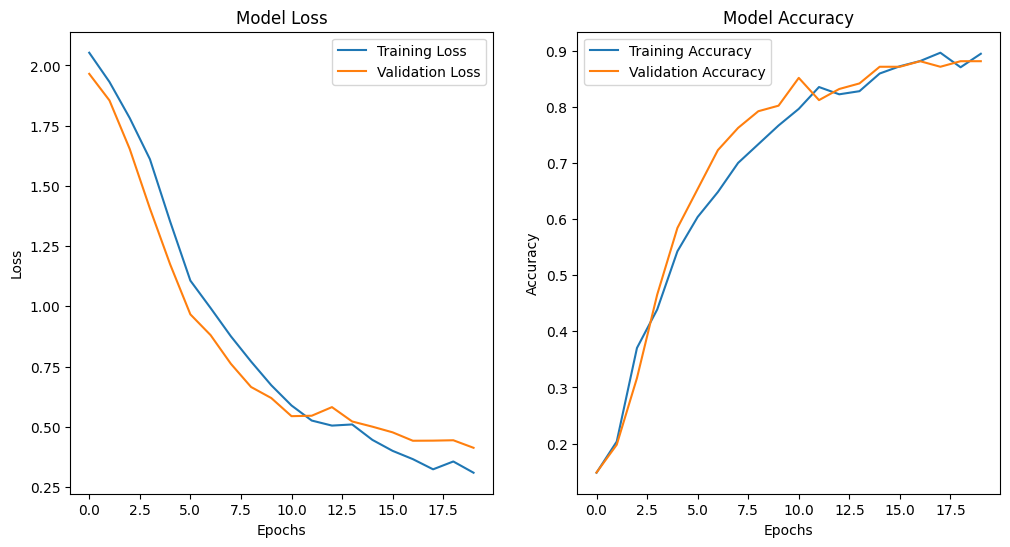

In [73]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


______________________
# Testing

In [74]:
# Evaluate model performance
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


img = cv2.imread("/kaggle/input/rock-data/scidb_data/Garnet/010().jpg")
img = cv2.resize(img, (150, 150))
img = img / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

prediction = model.predict(img)
predicted_class = np.argmax(prediction)
print(f"Predicted Class: {predicted_class}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8527 - loss: 0.5915 
Test Accuracy: 0.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted Class: 2


In [75]:
# List of mineral names (your classes)
class_names = ['Anorthosite', 'Augite', 'Garnet', 'Hornblende', 'Olivine', 'Oolite', 'Staurolite', 'Biotite', 'Chlorite']

# Read and preprocess the image
img = cv2.imread("/kaggle/input/rock-data/scidb_data/Garnet/010().jpg")
img = cv2.resize(img, (150, 150))
img = img / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict the class
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Map predicted class index to class name
predicted_class_name = class_names[predicted_class]

# Print the predicted class name
print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Class: Garnet


In [76]:
# Read and preprocess the image
img = cv2.imread("/kaggle/input/rock-data/scidb_data/Oolite/002().jpg")
img = cv2.resize(img, (150, 150))
img = img / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict the class
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Map predicted class index to class name
predicted_class_name = class_names[predicted_class]

# Print the predicted class name
print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Oolite


In [77]:

# Read and preprocess the image
img = cv2.imread("/kaggle/input/rock-data/scidb_data/Augite/006().jpg")
img = cv2.resize(img, (150, 150))
img = img / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict the class
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Map predicted class index to class name
predicted_class_name = class_names[predicted_class]

# Print the predicted class name
print(f"Predicted Class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Class: Augite


In [78]:

# Read and preprocess the image
img = cv2.imread("/kaggle/input/rock-data/scidb_data/Staurolite/003().jpg")
img = cv2.resize(img, (150, 150))
img = img / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict the class
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Map predicted class index to class name
predicted_class_name = class_names[predicted_class]

# Print the predicted class name
print(f"Predicted Class: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Staurolite


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


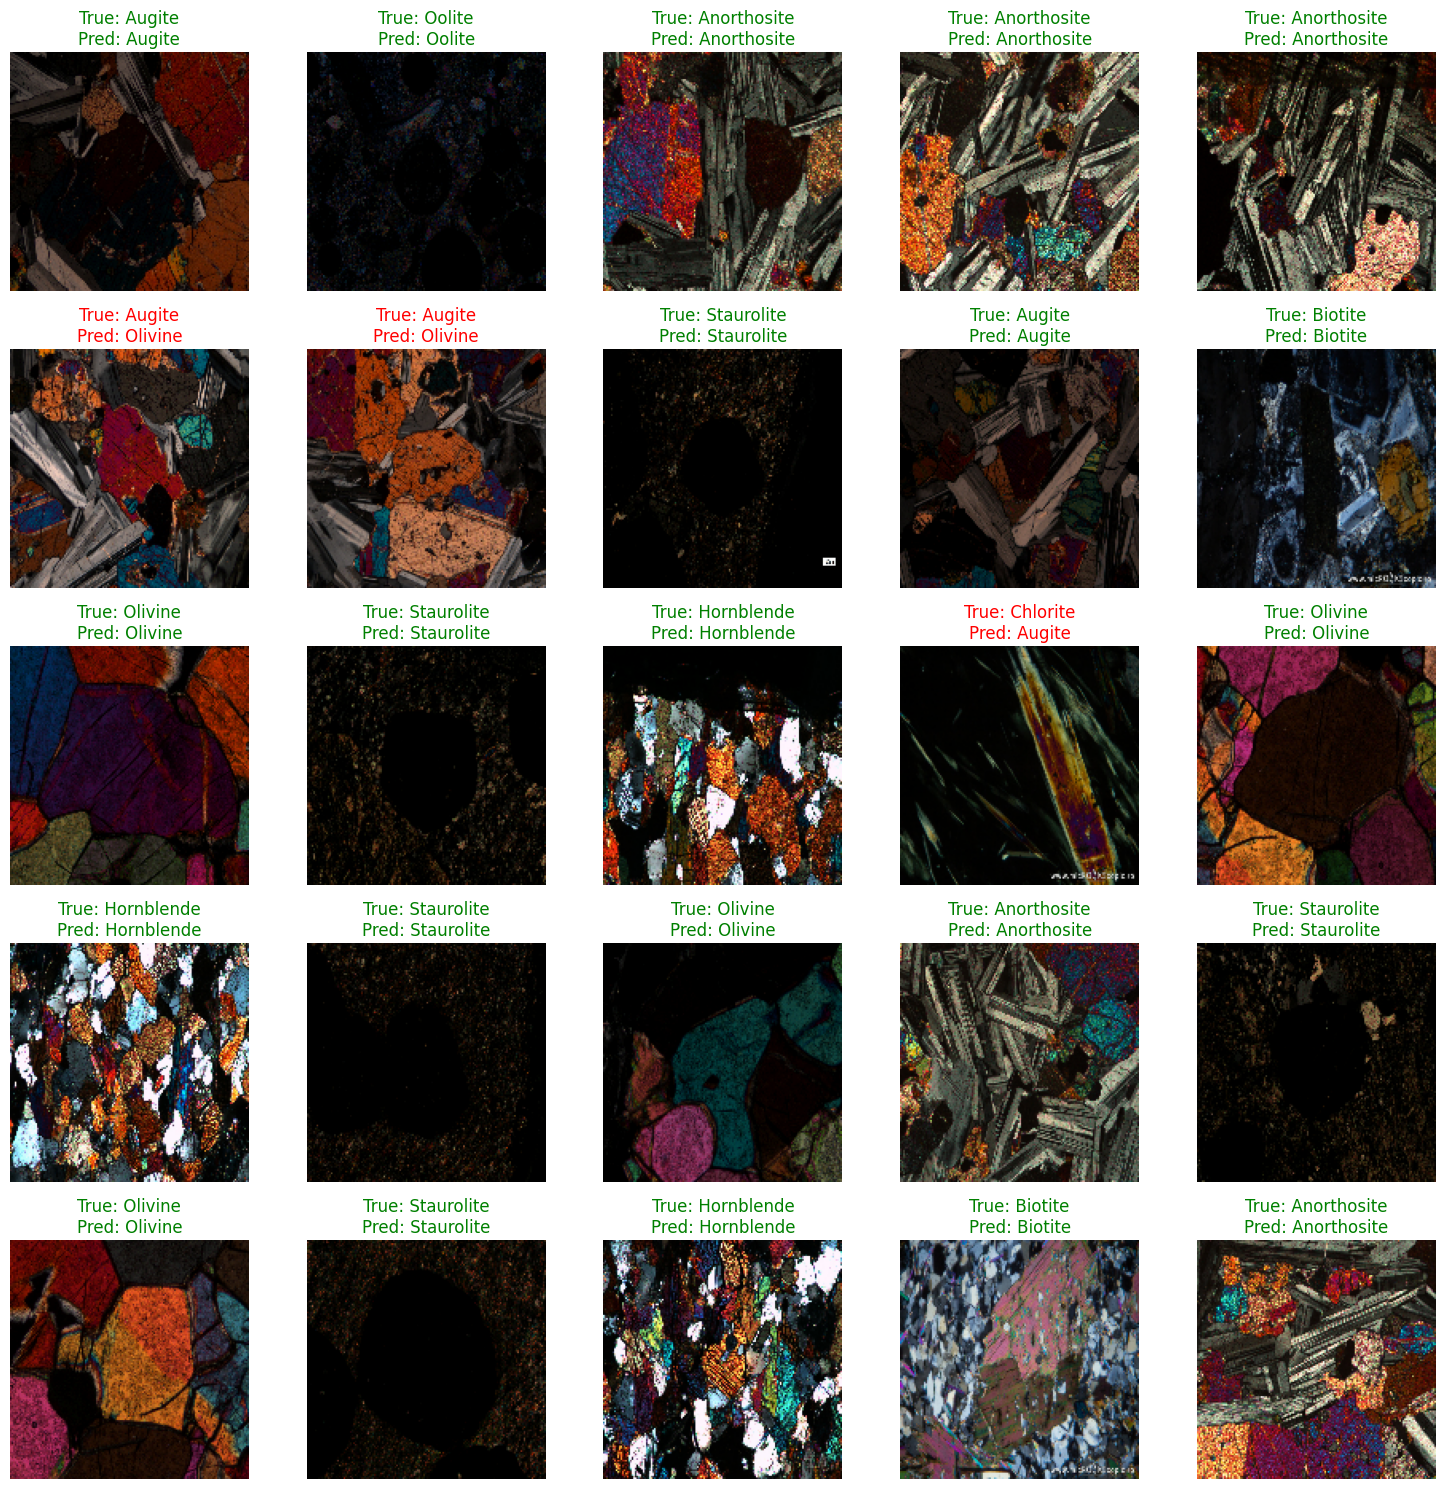

In [79]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 5, figsize=(15, 15))  
axes = axes.ravel()

# Plot the images
for i in range(25): 
    images, labels = next(iter(test_ds))  
    image = images[i].numpy()  
    true_label = np.argmax(labels[i].numpy())  
    predicted_label = np.argmax(model.predict(np.expand_dims(image, axis=0)), axis=1)[0] 
    
    
    image = np.clip(image * 255, 0, 255).astype('uint8')
    
   
    axes[i].imshow(image)
    
    
    if true_label != predicted_label:
        border_color = 'red'
        text_color = 'red'  # Set text color to red for incorrect predictions
    else:
        border_color = 'green'
        text_color = 'green'  # Set text color to green for correct predictions

    # Apply border color
    axes[i].spines['top'].set_color(border_color)
    axes[i].spines['top'].set_linewidth(2)
    axes[i].spines['bottom'].set_color(border_color)
    axes[i].spines['bottom'].set_linewidth(2)
    axes[i].spines['left'].set_color(border_color)
    axes[i].spines['left'].set_linewidth(2)
    axes[i].spines['right'].set_color(border_color)
    axes[i].spines['right'].set_linewidth(2)

    axes[i].set_title(
        f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}", 
        color=text_color  
    )
    
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [80]:
model_rock=model.save('rock_classification_model2.h5')

In [81]:
from IPython.display import FileLink

model_save_path = 'rock_classification_model2.h5'

FileLink(model_save_path)


/kaggle/working/rock_classification_model2.h5